In [162]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import imread, generic_filter
from scipy.misc import imresize
from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib 
%matplotlib inline

In [148]:
def load_data():
    lesion = []
    skin = []
    for folder in os.listdir('data')[0:20]:
        if os.path.isdir(os.path.join('data', folder)):
            image = equalize_adapthist(imread(os.path.join('data', folder, folder + '.bmp')))
            mask = imread(os.path.join('data', folder, folder + '_lesion.bmp'))
            lesion_mask = mask > 100
            skin_mask = mask < 100
            for row in image[lesion_mask]:
                lesion.append(row)
            for row in image[skin_mask]:
                skin.append(row)
        
    return (np.array(lesion), np.array(skin))

In [75]:
(lesion, skin) = load_data()

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [98]:
X = np.mat(np.concatenate((lesion, skin), axis=0))
y = np.mat(np.concatenate((np.full(len(lesion), 1), np.zeros(len(skin))), axis=0)).T

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(1909976, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [100]:
X_train[0:10,:]

matrix([[ 0.85978447,  0.78783598,  0.72308234],
        [ 0.83394518,  0.70375121,  0.65448862],
        [ 0.90447415,  0.8052026 ,  0.73166811],
        [ 0.31439417,  0.23341385,  0.22865031],
        [ 0.60300311,  0.43245678,  0.33500173],
        [ 0.78817132,  0.55971587,  0.49117923],
        [ 0.71713708,  0.56455473,  0.50733634],
        [ 0.46778043,  0.39057395,  0.35878305],
        [ 0.98614079,  0.7842537 ,  0.76095903],
        [ 0.70603675,  0.4354993 ,  0.28373439]])

In [103]:
print("Train dataset size: %d" % len(X_train))
print("Test dataset size: %d" % len(X_test))

Train dataset size: 5879730
Test dataset size: 2895987


In [104]:
train_size = 5000000
test_size = 5000000

In [105]:
logreg = linear_model.LogisticRegression(C=1e4)
logreg.fit(X_train[0:train_size,:], y_train[0:train_size,:])

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [106]:
accuracy = logreg.score(X_test[0:test_size,:], y_test[0:test_size,:])
print('Accuracy: %f' % accuracy)

Accuracy: 0.900288


In [83]:
def blur_image(img):
    footprint = np.array([[1,1,1],
                          [1,1,1],
                          [1,1,1]])
    return generic_filter(img, lambda values: nd.mean(values), footprint=footprint)

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


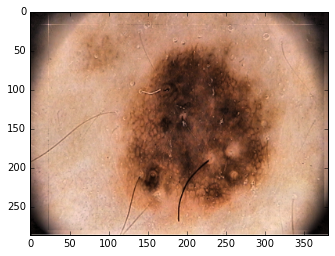

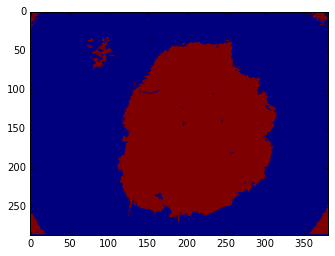

In [146]:
img = equalize_adapthist(imresize(imread('examples/IMD002.bmp'), 0.5))
(x,y,c) = img.shape
points = img.reshape(x * y, c)
labels = logreg.predict(points)
labeled_img = labels.reshape(x, y)
plt.imshow(img)
plt.show()
plt.imshow(labeled_img)
plt.show()


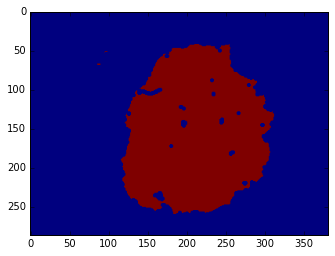

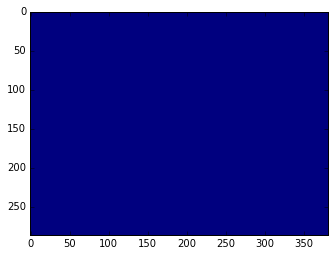

In [155]:
cleaned = gaussian(clear_border(labeled_img), sigma=1) > 0.99

plt.imshow(cleaned)
plt.show()
plt.imshow(slic(img, n_segments=2, compactness=1, sigma=0.5, 
                enforce_connectivity=True, convert2lab=True,
                max_size_factor=1))

In [156]:
min_neighbour_count = 3
def clean_image(labeled_img):
    footprint = np.array([[1,1,1],
                          [1,1,1],
                          [1,1,1]])
    def get_new_value(values):
        value = values[4]
        if (values.sum() - value) < min_neighbour_count:
            return 0
        else:
            return value
        
    
    return generic_filter(labeled_img, get_new_value, footprint=footprint)
    
margin = 40
def get_bounding_rect(labeled_img):
    cleaned_labeled_img = clean_image(labeled_img)
    left = labeled_img.shape[0]
    right = 0
    top = labeled_img.shape[1]
    bottom = 0
    
    for ix, row in enumerate(cleaned_labeled_img):
        for iy, value in enumerate(row):
            if value == 1:
                if ix < left:
                    left = ix
                if right < ix:
                    right = ix
                if iy < top:
                    top = iy
                if bottom < iy:
                    bottom = iy
    
    print((top, right, bottom, left))
    return img[left-margin:right+margin,top-margin:bottom+margin]

(86, 258, 311, 42)


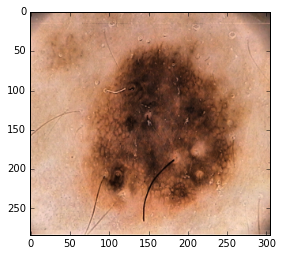

In [158]:
plt.imshow(get_bounding_rect(cleaned))

In [164]:
# save the classifier
joblib.dump(logreg, '../logreg_model.pkl')  

['../logreg_model.pkl',
 '../logreg_model.pkl_01.npy',
 '../logreg_model.pkl_02.npy',
 '../logreg_model.pkl_03.npy',
 '../logreg_model.pkl_04.npy']